<a href="https://colab.research.google.com/github/Nancy0000000/-/blob/main/%E6%95%B8%E6%93%9A%E5%A2%9E%E5%BC%B7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

113-1南華大學跨領域-人工智慧 主題:數據增強
報告學生:11220016陳靖尹 11218102蘇韋綾

數據增強：一種透過應用隨機（但真實）的變換（例如影像旋轉）來增加訓練集多樣性的技術。我們將學習如何透過兩種方式應用數據增強：
使用Keras 預處理層，例如tf.keras.layers.Resizing、tf.keras.layers.Rescaling、tf.keras.layers.RandomFlip和tf.keras.layers.RandomRotation。
使用tf.image方法，例如tf.image.flip_left_right、tf.image.rgb_to_grayscale、tf.image.adjust_brightness、tf.image.central_crop和tf.image.stateless_random*

設定

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds

from tensorflow.keras import layers

下載數據集
教程使用tf_flowers資料集。為了方便起見，請使用TensorFlow Datasets下載資料集。

In [4]:
(train_ds, val_ds, test_ds), metadata = tfds.load(
    'tf_flowers',
    split=['train[:80%]', 'train[80%:90%]', 'train[90%:]'],
    with_info=True,
    as_supervised=True,
)

Dl Completed...:   0%|          | 0/5 [00:00<?, ? file/s]

Dataset tf_flowers downloaded and prepared to /root/tensorflow_datasets/tf_flowers/3.0.1. Subsequent calls will reuse this data.


花卉數據集有五個類

In [5]:
num_classes = metadata.features['label'].num_classes
print(num_classes)

5


我們從數據集中檢索一個影像，然後使用它來演示資料增強。

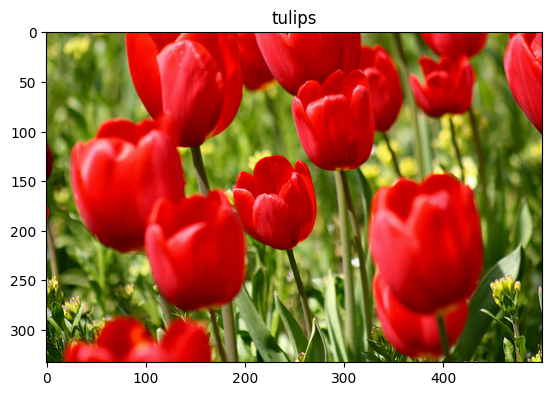

In [6]:
get_label_name = metadata.features['label'].int2str

image, label = next(iter(train_ds))
_ = plt.imshow(image)
_ = plt.title(get_label_name(label))

使用Keras 預處理層
調整大小和重新縮放
使用Keras 預處理圖層將影像大小調整為一致的形狀（使用tf.keras.layers.Resizing），並重新調整像素值（使用tf.keras.layers.Rescaling）。

In [7]:
IMG_SIZE = 180

resize_and_rescale = tf.keras.Sequential([
  layers.Resizing(IMG_SIZE, IMG_SIZE),
  layers.Rescaling(1./255)
])

注意：上面的重新縮放圖層將像素值標準化到[0,1]範圍。如果想要[-1,1]，可以寫tf.keras.layers.Rescaling(1./127.5, offset=-1)。

可以看到將這些圖層應用於影像的結果。

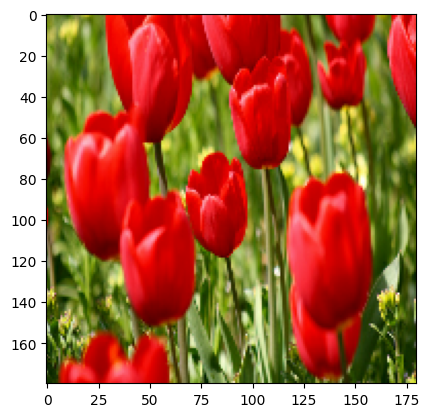

In [8]:
result = resize_and_rescale(image)
_ = plt.imshow(result)

驗證像素是否在[0, 1]範圍內：

In [9]:
print("Min and max pixel values:", result.numpy().min(), result.numpy().max())

Min and max pixel values: 0.0 1.0


數據增強

可以使用Keras 預處理層進行數據增強，例如tf.keras.layers.RandomFlip和tf.keras.layers.RandomRotation。
我們來建立一些預處理層，然後將它們重複應用於相同影像。

In [10]:
data_augmentation = tf.keras.Sequential([
  layers.RandomFlip("horizontal_and_vertical"),
  layers.RandomRotation(0.2),
])

In [11]:
# Add the image to a batch.
image = tf.cast(tf.expand_dims(image, 0), tf.float32)

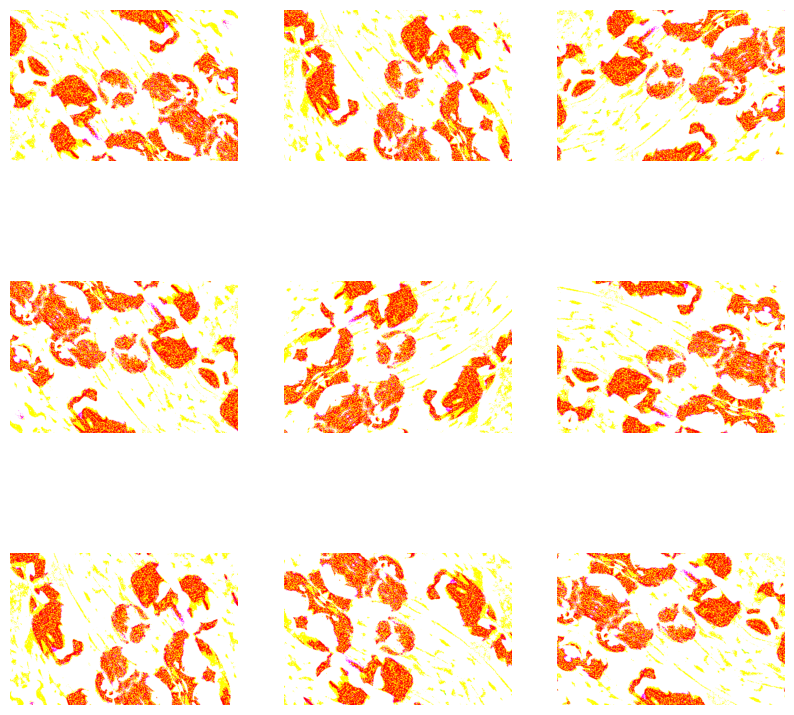

In [12]:
plt.figure(figsize=(10, 10))
for i in range(9):
  augmented_image = data_augmentation(image)
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(augmented_image[0])
  plt.axis("off")

有多種預處理層可用於數據增強，包括tf.keras.layers.RandomContrast、tf.keras.layers.RandomCrop、tf.keras.layers.RandomZoom等。

使用Keras 預處理層的兩個選項

您可以透過兩種方式使用這些預處理層，但需進行重要的權衡。

選項1：使預處理層成為模型的一部分

In [14]:
model = tf.keras.Sequential([
  # Add the preprocessing layers you created earlier.
  resize_and_rescale,
  data_augmentation,
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  # Rest of your model.
])

ValueError: Exception encountered when calling Sequential.call().

[1mInput 0 of layer "functional_1" is incompatible with the layer: expected shape=(None, 333, 500, 3), found shape=(180, 180, 3)[0m

Arguments received by Sequential.call():
  • args=('<KerasTensor shape=(180, 180, 3), dtype=float32, sparse=False, name=keras_tensor_9>',)
  • kwargs={'mask': 'None'}

在這種情況下，需要注意兩個要點：
資料增強將與其他層在裝置端同步運行，並受益於GPU 加速。
使用model.save匯出模型時，預處理層將與模型的其他部分一起儲存。如果稍後部署此模型，它將自動標準化映像（根據您的層配置）。這可以省去在伺服器端重新實作該邏輯的工作。
注意：資料增強在測試時處於停用狀態，因此只有在呼叫Model.fit（而非Model.evaluate或Model.predict）期間才會對輸入影像進行增強。

選項2：將預處理層應用於資料集

aug_ds = train_ds.map(
  lambda x, y: (resize_and_rescale(x, training=True), y))

透過這種方式，您可以使用Dataset.map建立產生增強影像批次的資料集。在本例中：
資料增強將在CPU 上非同步進行，且為非阻塞性。您可以使用Dataset.prefetch將GPU 上的模型訓練與資料資料預處理重疊，如下所示。
在本例中，當呼叫Model.save時，預處理層將不會隨模型一起匯出。在保存模型或在伺服器端重新實作它們之前，您需要將它們附加到模型上。訓練後，您可以在匯出之前附加預處理層。

將預處理層應用於資料集
使用上面建立的Keras 預處理層配置訓練數據集、數據資料集和測試數據集。您還將配置數據集以提高效能，具體方式是使用並行讀取和緩衝預提取從磁碟產生批次，這樣不會阻塞I/O。 （您可以透過使用tf.data API 提高效能指南來詳細了解資料集效能）。
註：應僅對訓練集應用數據增強。

In [15]:
batch_size = 32
AUTOTUNE = tf.data.AUTOTUNE

def prepare(ds, shuffle=False, augment=False):
  # Resize and rescale all datasets.
  ds = ds.map(lambda x, y: (resize_and_rescale(x), y),
              num_parallel_calls=AUTOTUNE)

  if shuffle:
    ds = ds.shuffle(1000)

  # Batch all datasets.
  ds = ds.batch(batch_size)

  # Use data augmentation only on the training set.
  if augment:
    ds = ds.map(lambda x, y: (data_augmentation(x, training=True), y),
                num_parallel_calls=AUTOTUNE)

  # Use buffered prefetching on all datasets.
  return ds.prefetch(buffer_size=AUTOTUNE)

In [16]:
train_ds = prepare(train_ds, shuffle=True, augment=True)
val_ds = prepare(val_ds)
test_ds = prepare(test_ds)

訓練模型

為了完整起見，您現在將使用剛剛準備的數據集訓練模型。
序貫模型由三個卷積塊( tf.keras.layers.Conv2D) 組成，每個卷積塊都有一個最大池化層( tf.keras.layers.MaxPooling2D)。有一個全連接層( tf.keras.layers.Dense)，上面有128 個單元，由ReLU 激活函數( 'relu') 激活。此模型尚未針對準確率進行調整（目標是展示機制）。

In [17]:
model = tf.keras.Sequential([
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

選擇tf.keras.optimizers.Adam最佳化器和tf.keras.losses.SparseCategoricalCrossentropy損失函數。若要查看每個訓練週期的訓練和驗證準確率，請將metrics參數傳遞給Model.compile

In [18]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

訓練幾個週期：

In [ ]:
epochs=5
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/5
46/92 ━━━━━━━━━━━━━━━━━━━━ 1:10 2s/step - accuracy: 0.4449 - loss: 1.2883

In [ ]:
loss, acc = model.evaluate(test_ds)
print("Accuracy", acc)

自訂數據增強

也可以建立自訂數據增強層。
教程的這一部分展示了兩種操作方式：
首先，建立一個tf.keras.layers.Lambda層。這是編寫簡潔程式碼的好方式。
接下來，將透過子類化編寫一個新層，這會給您更多的控制。
兩個層都會根據某種機率隨機反轉影像中的顏色。

In [ ]:
def random_invert_img(x, p=0.5):
  if  tf.random.uniform([]) < p:
    x = (255-x)
  else:
    x
  return x

In [ ]:
def random_invert(factor=0.5):
  return layers.Lambda(lambda x: random_invert_img(x, factor))

random_invert = random_invert()

In [ ]:
plt.figure(figsize=(10, 10))
for i in range(9):
  augmented_image = random_invert(image)
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(augmented_image[0].numpy().astype("uint8"))
  plt.axis("off")

接下來，透過子類化實現自訂層：

In [ ]:
class RandomInvert(layers.Layer):
  def __init__(self, factor=0.5, **kwargs):
    super().__init__(**kwargs)
    self.factor = factor

  def call(self, x):
    return random_invert_img(x)

In [ ]:
_ = plt.imshow(RandomInvert()(image)[0])

使用tf.image

上述Keras 預訓練實用工具十分方便。但為了更精細的控制，您可以使用tf.data和tf.image編寫自己的資料增強管線或資料增強層。您也可以查看TensorFlow Addons 影像：運算和TensorFlow I/O：色彩空間轉換。
由於花卉資料集之前已經配置了資料增強，因此我們將其重新導入以重新開始。

In [ ]:
(train_ds, val_ds, test_ds), metadata = tfds.load(
    'tf_flowers',
    split=['train[:80%]', 'train[80%:90%]', 'train[90%:]'],
    with_info=True,
    as_supervised=True,
)

檢索一個影像以供使用：

In [ ]:
image, label = next(iter(train_ds))
_ = plt.imshow(image)
_ = plt.title(get_label_name(label))

我們來使用以下函數呈現原始影像和增強影像，然後並排比較。

In [ ]:
def visualize(original, augmented):
  fig = plt.figure()
  plt.subplot(1,2,1)
  plt.title('Original image')
  plt.imshow(original)

  plt.subplot(1,2,2)
  plt.title('Augmented image')
  plt.imshow(augmented)

翻轉影像

使用tf.image.flip_left_right垂直或水平翻轉影像：

In [ ]:
flipped = tf.image.flip_left_right(image)
visualize(image, flipped)

對影像進行灰階處理

您可以使用tf.image.rgb_to_grayscale對影像進行灰階處理：

In [ ]:
grayscaled = tf.image.rgb_to_grayscale(image)
visualize(image, tf.squeeze(grayscaled))
_ = plt.colorbar()

調整影像飽和度

使用tf.image.adjust_saturation，透過提供飽和係數來調整影像飽和度：

In [ ]:
saturated = tf.image.adjust_saturation(image, 3)
visualize(image, saturated)

更改影像亮度

使用tf.image.adjust_brightness，透過提供亮度係數來更改圖像的亮度：

In [ ]:
bright = tf.image.adjust_brightness(image, 0.4)
visualize(image, bright)

對影像進行中心裁剪

使用tf.image.central_crop將影像從中心裁切到所需部分：

In [ ]:
cropped = tf.image.central_crop(image, central_fraction=0.5)
visualize(image, cropped)

旋轉影像

使用tf.image.rot90將影像旋轉90 度：

In [ ]:
rotated = tf.image.rot90(image)
visualize(image, rotated)

隨機變換

警告：有兩組隨機圖像運算：tf.image.random*和tf.image.stateless_random*。強烈不建議使用tf.image.random*運算，因為它們使用的是TF 1.x 中的舊RNG。請改用本教學中介紹的隨機圖像運算。有關詳情，請參閱隨機數產生。
對影像應用隨機變換可以進一步幫助泛化和擴展資料集。目前的tf.imageAPI 提供了8 個這樣的隨機影像運算(op)：

*   tf.image.stateless_random_brightness
*   tf.image.stateless_random_contrast
*   tf.image.stateless_random_crop
*   tf.image.stateless_random_flip_left_right
*   tf.image.stateless_random_flip_up_down
*   tf.image.stateless_random_hue
*   tf.image.stateless_random_jpeg_quality
*   tf.image.stateless_random_saturation


這些隨機圖像運算純粹是功能性的：輸出僅取決於輸入。這使得它們易於在高性能、確定性的輸入管線中使用。它們要求每一步都輸入一個seed值。給定相同的seed，無論被呼叫多少次，它們都會傳回相同的結果。
註：seed是形狀為(2,)的Tensor，其值為任意整數。

在以下部分中，您將：
回顧使用隨機影像運算來變換影像的範例。
示範如何將隨機變換應用於訓練資料集。

隨機更改影像亮度

透過提供亮度係數和seed，使用tf.image.stateless_random_brightness隨機變更image的亮度。亮度係數在[-max_delta, max_delta)範圍內隨機選擇，並與給定的seed相關聯。

In [ ]:
for i in range(3):
  seed = (i, 0)  # tuple of size (2,)
  stateless_random_brightness = tf.image.stateless_random_brightness(
      image, max_delta=0.95, seed=seed)
  visualize(image, stateless_random_brightness)

隨機更改影像對比度

透過提供對比範圍和seed，使用tf.image.stateless_random_contrast隨機變更image的對比。對比範圍在區間[lower, upper]中隨機選擇，並與給定的seed相關聯。

In [ ]:
for i in range(3):
  seed = (i, 0)  # tuple of size (2,)
  stateless_random_contrast = tf.image.stateless_random_contrast(
      image, lower=0.1, upper=0.9, seed=seed)
  visualize(image, stateless_random_contrast)

隨機裁剪影像

透過提供目標size和seed，使用tf.image.stateless_random_crop隨機裁剪image。從image中裁剪出來的部分位於隨機選擇的偏移處，並與給定的seed相關聯。

In [ ]:
for i in range(3):
  seed = (i, 0)  # tuple of size (2,)
  stateless_random_crop = tf.image.stateless_random_crop(
      image, size=[210, 300, 3], seed=seed)
  visualize(image, stateless_random_crop)

對資料集應用增強

我們首先再次下載圖像資料集，以防它們在先前的部分中被修改

In [ ]:
(train_datasets, val_ds, test_ds), metadata = tfds.load(
    'tf_flowers',
    split=['train[:80%]', 'train[80%:90%]', 'train[90%:]'],
    with_info=True,
    as_supervised=True,
)

接下來，定義一個用於調整影像大小和重新縮放影像的效用函數。此函數將用於統一資料集中影像的大小和比例：

In [ ]:
def resize_and_rescale(image, label):
  image = tf.cast(image, tf.float32)
  image = tf.image.resize(image, [IMG_SIZE, IMG_SIZE])
  image = (image / 255.0)
  return image, label

我們同時定義augment函數，該函數可以將隨機變換應用於影像。此函數將在下一步中用於資料集。

In [ ]:
def augment(image_label, seed):
  image, label = image_label
  image, label = resize_and_rescale(image, label)
  image = tf.image.resize_with_crop_or_pad(image, IMG_SIZE + 6, IMG_SIZE + 6)
  # Make a new seed.
  new_seed = tf.random.split(seed, num=1)[0, :]
  # Random crop back to the original size.
  image = tf.image.stateless_random_crop(
      image, size=[IMG_SIZE, IMG_SIZE, 3], seed=seed)
  # Random brightness.
  image = tf.image.stateless_random_brightness(
      image, max_delta=0.5, seed=new_seed)
  image = tf.clip_by_value(image, 0, 1)
  return image, label

選項1：使用tf.data.experimental.Counter

建立一個tf.data.experimental.Counter()物件（我們稱之為counter)，並使用(counter, counter) Dataset.zip資料集。這將確保資料集中的每個影像都與一個基於counter的唯一值（形狀為(2,)）相關聯，稍後可以將其傳遞到augment函數，作為隨機變換的seed值。

In [ ]:
# Create a `Counter` object and `Dataset.zip` it together with the training set.
counter = tf.data.experimental.Counter()
train_ds = tf.data.Dataset.zip((train_datasets, (counter, counter)))

將augment函數映射到訓練資料集：

In [ ]:
train_ds = (
    train_ds
    .shuffle(1000)
    .map(augment, num_parallel_calls=AUTOTUNE)
    .batch(batch_size)
    .prefetch(AUTOTUNE)
)

In [ ]:
val_ds = (
    val_ds
    .map(resize_and_rescale, num_parallel_calls=AUTOTUNE)
    .batch(batch_size)
    .prefetch(AUTOTUNE)
)

In [ ]:
test_ds = (
    test_ds
    .map(resize_and_rescale, num_parallel_calls=AUTOTUNE)
    .batch(batch_size)
    .prefetch(AUTOTUNE)
)

選項2：使用tf.random.Generator

建立一個具有初始 值seed的tf.random.Generator物件。在同一個生成器物件上呼叫make_seeds函數會始終傳回一個新的、唯一的seed值。
定義一個封裝容器函數：1) 呼叫make_seeds函數；2) 將新產生的seed值傳遞給augment函數進行隨機變換。
注意：tf.random.Generator物件會將RNG 狀態儲存在tf.Variable中，這表示它可以儲存為檢查點或以SavedModel格式儲存。有關詳情，請參閱隨機數產生。

In [ ]:
# Create a generator.
rng = tf.random.Generator.from_seed(123, alg='philox')

In [ ]:
# Create a wrapper function for updating seeds.
def f(x, y):
  seed = rng.make_seeds(2)[0]
  image, label = augment((x, y), seed)
  return image, label

將封裝容器函數f對應到訓練資料集，並將resize_and_rescale函數對應到驗證集和測試集：

In [ ]:
train_ds = (
    train_datasets
    .shuffle(1000)
    .map(f, num_parallel_calls=AUTOTUNE)
    .batch(batch_size)
    .prefetch(AUTOTUNE)
)

In [ ]:
val_ds = (
    val_ds
    .map(resize_and_rescale, num_parallel_calls=AUTOTUNE)
    .batch(batch_size)
    .prefetch(AUTOTUNE)
)

In [ ]:
test_ds = (
    test_ds
    .map(resize_and_rescale, num_parallel_calls=AUTOTUNE)
    .batch(batch_size)
    .prefetch(AUTOTUNE)
)

後續步驟

本教學示範了使用Keras 預處理層和tf.image進行資料增強。
若要了解如何在模型中包含預處理層，請參閱影像分類教學。
您可能也有興趣了解預處理層如何幫助您對文字進行分類，請參閱基本文字分類教學。
您可以在此指南中了解有關tf.data的更多信息，並且可以在這裡了解如何配置輸入流水線以提高性能。
